In [18]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from ast import literal_eval
from typing import List
import re
import importlib

import context
os.chdir(context.proj_dir)

import cont_gen.utils
importlib.reload(cont_gen.utils)
import cont_gen.evaluate.cal_metrics
importlib.reload(cont_gen.evaluate.cal_metrics)
from cont_gen.utils import load_jsonl, save_jsonl, plot_multiple_loss, get_loss_df_norm,get_ckpt_paths, load_json, save_json
from cont_gen.evaluate.cal_metrics import cal_collective_point_metrics, get_point_counts, get_doc_metrics, get_overall_metrics
import cont_gen.evaluate.io
importlib.reload(cont_gen.evaluate.io)
from cont_gen.evaluate.io import RunManager

In [2]:
# test_data_id = load_jsonl('data/ood_split/seed42_tr29/pmt_01/test_data_id.jsonl')
# test_data_ood = load_jsonl('data/ood_split/seed42_tr29/pmt_01/test_data_ood.jsonl')
cvt = {'answers': lambda k: ' '.join(literal_eval(k))}

tkn_name = 'flan-t5'
test_meta_id = pd.read_csv(f'data/ood_split/seed42_tr29/{tkn_name}/test_meta_id.csv', converters = cvt)
test_meta_ood = pd.read_csv(f'data/ood_split/seed42_tr29/{tkn_name}/test_meta_ood.csv', converters = cvt)

print(test_meta_ood.columns)
print(test_meta_ood.iloc[0].answers)

Index(['title', 'para_idx', 'q_id', 'answers', 'type'], dtype='object')
SUPPLY CONTRACT


In [3]:
def parse_pred(text: str):
    if text == 'No' or text == 'No.':
        return ''
    else:
        return text.removeprefix('Yes.')

In [8]:
# This is an example
run_dir = Path('runs/ood/t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0')
# run_dir = Path('runs/ood/llama3_chat/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0')
# run_dir = Path('runs/ood/mistral/seed42_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)

pred_path = ckpt_dirs[0] / f'predictions_ood_sampled.jsonl'
pred_df = pd.DataFrame(load_jsonl(pred_path))
pred_df['prediction'] = pred_df['prediction'].apply(parse_pred)

ov_mets, detail_df = get_overall_metrics(test_meta_ood, pred_df, lambda k: k)
print(ov_mets)

{'micro_p': 0.03217318136617456, 'micro_r': 0.10611029819869822, 'micro_f1': 0.04937546957175056, 'micro_iou': 0.02531264669419001, 'macro_p': 0.02802847141949866, 'macro_r': 0.08791422378293313, 'macro_f1': 0.040198119671551936, 'macro_iou': 0.020889024866615147, 'doc_macro_p': 0.35347017268498937, 'doc_macro_r': 0.6742461800220525, 'doc_macro_f1': 0.2408546419743437, 'doc_macro_iou': 0.23295865998205725}


In [6]:
detail_df

,q_id,macro_p,macro_r,macro_f1,macro_iou,doc_macro_p,doc_macro_r,doc_macro_f1,doc_macro_iou
0,0,0.385263,0.516949,0.441496,0.283282,0.675885,0.531182,0.429570,0.401444
1,1,0.336603,0.282844,0.307391,0.181608,0.666812,0.386982,0.290121,0.214509
2,5,0.913462,0.316140,0.469716,0.306947,0.974963,0.875835,0.881652,0.870350
3,6,0.464020,0.463445,0.463732,0.301856,0.901961,0.925966,0.855976,0.847535
4,7,0.961353,0.804484,0.875950,0.779281,0.985924,0.864924,0.875654,0.851210
5,8,1.000000,0.000000,0.000000,0.000000,1.000000,0.970588,0.970588,0.970588
6,14,0.945498,0.566761,0.708703,0.548831,0.995269,0.963938,0.967635,0.962598
7,15,0.605744,0.528073,0.564248,0.392998,0.896965,0.885742,0.797997,0.787937
8,17,0.752448,0.159360,0.263016,0.151421,0.962550,0.796807,0.795429,0.784138
9,27,0.949675,0.336207,0.496604,0.330322,0.997770,0.961713,0.970386,0.961474


In [9]:
pred_df['prediction']

0        - The buyer entrusts YICHANGTAI IMPORT AND EXP...
1        - The buyer entrusts the entrusted party to pu...
2        entrusted party to accept orders issued by the...
3        entrusted party to accept orders and modify or...
4        entrusted party to purchase the goods specifie...
                               ...                        
11911    shall be enforceable in accordance with the te...
11912    shall be enforceable in accordance with the te...
11913    shall be enforceable in accordance with the te...
11914    shall be enforceable in accordance with the te...
11915                                                     
Name: prediction, Length: 11916, dtype: object

## Run Manage

In [4]:
# Print runs to cal metric and to infer
top_dir = Path('runs/ood')
run_man = RunManager(top_dir, is_ood = True)

print(run_man.get_runs_to_cal_met())
runs_to_infer = [k for k in run_man.get_runs_to_infer() if 'bos' not in k]
print(runs_to_infer)

{'runs/ood/t5-large/seed42_tr29/pmt_01_lr1e-3_bs16_wd0.0', 'runs/ood/t5-large/seed42_tr29/pmt_01_lr2e-4_bs16_wd0.0', 'runs/ood/t5-large/seed42_tr29/pmt_01_lr5e-4_bs16_wd0.0', 'runs/ood/t5-large/seed89_tr29/pmt_01_lr5e-4_bs16_wd0.0', 'runs/ood/t5-large/seed128_tr29/pmt_01_lr1e-3_bs16_wd0.0', 'runs/ood/t5-large/seed89_tr29/pmt_01_lr2e-4_bs16_wd0.0', 'runs/ood/t5-large/seed89_tr29/pmt_01_lr1e-3_bs16_wd0.0', 'runs/ood/t5-large/seed128_tr29/pmt_01_lr5e-4_bs16_wd0.0'}
['runs/ood/mistral/seed89_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0', 'runs/ood/t5-large/seed128_tr29/pmt_01_lr2e-4_bs16_wd0.0', 'runs/ood/llama3_chat/seed128_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0', 'runs/ood/llama3_chat/seed89_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0', 'runs/ood/mistral/seed128_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0']


In [5]:
# Print runs to cal metric and to infer for ID
run_man_id = RunManager(top_dir, is_ood = False)

print(run_man_id.get_runs_to_cal_met())
runs_to_infer_id = [k for k in run_man_id.get_runs_to_infer() if 'bos' not in k]
print(runs_to_infer_id)

{'runs/ood/t5-large/seed42_tr29/pmt_01_lr1e-3_bs16_wd0.0', 'runs/ood/t5-large/seed42_tr29/pmt_01_lr2e-4_bs16_wd0.0', 'runs/ood/t5-large/seed42_tr29/pmt_01_lr5e-4_bs16_wd0.0', 'runs/ood/t5-large/seed89_tr29/pmt_01_lr5e-4_bs16_wd0.0', 'runs/ood/t5-large/seed128_tr29/pmt_01_lr1e-3_bs16_wd0.0', 'runs/ood/t5-large/seed89_tr29/pmt_01_lr2e-4_bs16_wd0.0', 'runs/ood/t5-large/seed89_tr29/pmt_01_lr1e-3_bs16_wd0.0', 'runs/ood/t5-large/seed128_tr29/pmt_01_lr5e-4_bs16_wd0.0'}
['runs/ood/mistral/seed89_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0', 'runs/ood/llama3/seed128_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0', 'runs/ood/t5-large/seed128_tr29/pmt_01_lr2e-4_bs16_wd0.0', 'runs/ood/t5-large/seed89_tr29/pmt_01_lr2e-4_bs16_wd0.0', 'runs/ood/llama3_chat/seed128_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0', 'runs/ood/llama3_chat/seed89_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0', 'runs/ood/mistral/seed128_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0']


In [23]:
pred_df = pd.DataFrame(load_jsonl('runs/ood/llama3_bos/seed89_tr29/pmt_01_all_lr1e-5_bs16_wd0.0/checkpoint-16484/predictions_ood_all.jsonl'))
test_meta_ood = pd.read_csv(f'data/ood_split/seed42_tr29/llama3/test_meta_ood.csv', converters = cvt)
print(len(test_meta_ood))
print(len(pred_df))
gr_rec = set(map(tuple, pred_df[pred_df['type'] > 0][['title', 'para_idx', 'q_id']].values.tolist()))
pr_rec = set(map(tuple, pred_df[['title', 'para_idx', 'q_id']].values.tolist()))

miss = [k for k in gr_rec if k not in pr_rec]
print(len(miss))

67188
67188
0


In [73]:
run_man.scan_top()

run_man.ckpt_details[run_man.ckpt_details['run_path'] == 'runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0']

,run_path,ckpt,pred_all,pred_sampled,metric_all,metric_sampled
110,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-15692,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...
111,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-31384,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...
112,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-47076,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...
113,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-62768,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...
114,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-78460,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...


### Calculate Metrics

In [6]:
def get_tk_name(path):
    if 't5' in path:
        tk_name = 'flan-t5'
    elif 'llama3' in path:
        tk_name = 'llama3'
    elif 'mistral' in path:
        tk_name = 'mistral'
    else:
        print(f'missing tk_name for {path}')
        tk_name = None
    return tk_name

In [9]:
dist = 'id'
cvt = {'answers': lambda k: ' '.join(literal_eval(k))}
if dist == 'ood':
    cur_man = run_man
else:
    cur_man = run_man_id
cur_man.scan_top()
run_paths = cur_man.get_runs_to_cal_met()
print(len(run_paths))
for run_path in run_paths:
    print(f'Handle run {run_path}')
    # find tk_name
    if 't5' in run_path:
        tk_name = 'flan-t5'
    elif 'llama3' in run_path:
        tk_name = 'llama3'
    elif 'mistral' in run_path:
        tk_name = 'mistral'
    else:
        print(f'missing tk_name for {run_path}')
        continue
    split = Path(run_path).parts[-2]
    test_meta_ood = pd.read_csv(f'data/ood_split/{split}/{tk_name}/test_meta_{dist}.csv', converters = cvt)
    cur_man.cal_metrics_for_run(run_path, test_meta_ood, parse_pred)

0


In [20]:
# print metrics for one run
run_path = 'runs/ood/mistral/seed89_tr29/pmt_01_all_lr1e-5_bs16_wd0.0'
rep_met = 'macro_iou'
ood_steps, ood_mets = run_man.get_run_metrics(run_path, part = 'sampled')
id_steps, id_mets = run_man_id.get_run_metrics(run_path, part = 'sampled')
print(f'{len(ood_steps)}, {len(id_steps)}')
if (ood_steps or id_steps):
    if len(id_steps) > 0:
        # find ckpt with best id
        max_i = np.argmax(id_mets[rep_met].to_list())
        best_step_id = id_steps[max_i]

        ood_i = ood_steps.index(best_step_id)
        print('Best epoch: ', ood_i)
        run_mets = ood_mets.iloc[ood_i].to_dict()
    else:
        best_i = np.argmax(ood_mets[rep_met].to_list())
        print('Best epoch: ', best_i)
        run_mets = ood_mets.iloc[best_i].to_dict()
    keys = [f'{a}_{b}' for a in ['macro', 'micro'] for b in ['p', 'r', 'f1', 'iou']]
    values = [run_mets[k] for k in keys]
    v_str = [f'{k*100:.2f}' for k in values]
    print(keys)
    print('\t'.join(v_str))

5, 5
Best epoch:  3
['macro_p', 'macro_r', 'macro_f1', 'macro_iou', 'micro_p', 'micro_r', 'micro_f1', 'micro_iou']
77.34	39.25	46.68	34.29	75.88	41.94	54.02	37.01


In [17]:
id_mets

,doc_macro_f1,doc_macro_iou,doc_macro_p,doc_macro_r,macro_f1,macro_iou,macro_p,macro_r,micro_f1,micro_iou,micro_p,micro_r
0,0.204797,0.196777,0.231785,0.779599,0.035237,0.018144,0.022652,0.142792,0.034387,0.017494,0.020747,0.100387
1,0.162191,0.150768,0.169720,0.807593,0.037890,0.019517,0.022432,0.223229,0.037475,0.019095,0.021028,0.172029
2,0.154592,0.142943,0.156367,0.818278,0.034332,0.017639,0.019445,0.256639,0.032780,0.016663,0.017848,0.200645
3,0.211272,0.200308,0.224687,0.809032,0.038372,0.019906,0.022941,0.209606,0.032395,0.016464,0.018048,0.158020
4,0.237651,0.227237,0.254772,0.804301,0.039103,0.020330,0.024086,0.194657,0.033333,0.016949,0.018931,0.139342


In [14]:
ood_mets

,doc_macro_f1,doc_macro_iou,doc_macro_p,doc_macro_r,macro_f1,macro_iou,macro_p,macro_r,micro_f1,micro_iou,micro_p,micro_r
0,0.751984,0.743529,0.963737,0.765026,0.142655,0.082025,0.708667,0.176678,0.175624,0.096265,0.624893,0.102169
1,0.800513,0.778447,0.892485,0.850116,0.354649,0.237799,0.596096,0.392658,0.456463,0.295725,0.574039,0.378863
2,0.803273,0.780445,0.898886,0.850024,0.356888,0.242621,0.630320,0.390299,0.467068,0.304689,0.604460,0.380566
3,0.798526,0.779479,0.926541,0.821688,0.303998,0.197788,0.688727,0.317699,0.395347,0.246375,0.649544,0.284147
4,0.802612,0.781338,0.910671,0.840161,0.350684,0.235850,0.679559,0.371533,0.447483,0.288230,0.621908,0.349468


In [13]:
run_man.runs

,model,split,run_name,has_pred,has_metric
0,mixtral,seed42_tr29,pmt_01_all_lr1e-5_bs16_wd0.0,0,0
1,t5-large,seed42_tr29,pmt_01_yes_no_lr1e-4_bs16_wd0.0,1,1
2,t5-large,seed42_tr29,pmt_01_lr1e-4_bs16_wd0.0,1,1
3,t5-large,seed128_tr29,pmt_01_lr1e-4_bs16_wd0.0,1,0
4,t5-large,seed128_tr29,pmt_01_yes_no_lr1e-4_bs16_wd0.0,1,1
5,t5-large,seed89_tr29,pmt_01_lr1e-4_bs16_wd0.0,1,1
6,t5-large,seed89_tr29,pmt_01_yes_no_lr1e-4_bs16_wd0.0,1,1
7,flan-t5-xl,seed42_tr29,pmt_01_lr1e-4_bs16_wd0.0,0,0
8,flan-t5-xl,seed128_tr29,pmt_01_lr1e-4_bs16_wd0.0,0,0
9,flan-t5-xl,seed89_tr29,pmt_01_lr1e-4_bs16_wd0.0,0,0


### Calculate Metrics of Baselines

In [32]:
split = 'seed42_tr29'
run_dir = Path(f'runs/baseline/flan-t5-xl/{split}/pmt_01')

tk_name = get_tk_name(str(run_dir))

# Different parse function for flan-t5-xl and llama3-instruct
def parse_pred_zs_llama3(row):
    text = row['prediction']
    if 'No' in text and 'Yes' not in text:
        return ''
    return text

def get_parse_zs_flan():
    para_data = load_jsonl('data/cuad_clean/merge_split/paras_flan-t5_512.jsonl')
    tit2paras = {k['title']: k['paras'] for k in para_data}

    def parse(row):
        text = row['prediction']
        if text == 'No':
            return ''
        if text == 'Yes':
            para_text = tit2paras[row['title']][row['para_idx']]['text']
            return para_text
        return text
    return parse

for ood in ['ood']:
    test_meta_id = pd.read_csv(f'data/ood_split/{split}/{tk_name}/test_meta_{ood}.csv', converters = cvt)

    pred_sampled_df = pd.DataFrame(load_jsonl(run_dir / f'predictions_{ood}_sampled.jsonl'))
    if tk_name == 'flan-t5':
        apply_fn = get_parse_zs_flan()
    elif tk_name == 'llama3':
        apply_fn = parse_pred_zs_llama3
    pred_sampled_df['prediction'] = pred_sampled_df.apply(apply_fn, axis = 1)

    ov_mets_sampled, detail_df_sampled = get_overall_metrics(test_meta_id, pred_sampled_df, lambda k: k)
    save_json(ov_mets_sampled, run_dir / f'ov_metrics_{ood}_sampled.csv')
    detail_df_sampled.to_csv(run_dir / f'detail_metrics_{ood}_sampled.csv', index = False)

    keys = [f'{a}_{b}' for a in ['macro', 'micro'] for b in ['p', 'r', 'f1', 'iou']]
    values = [ov_mets_sampled[k] for k in keys]
    v_str = [f'{k*100:.2f}' for k in values]

    print(ood)
    print(keys)
    print('\t'.join(v_str))

ood
['macro_p', 'macro_r', 'macro_f1', 'macro_iou', 'micro_p', 'micro_r', 'micro_f1', 'micro_iou']
19.31	64.70	26.24	15.97	13.64	68.01	22.73	12.82


In [19]:
pred_sampled_df.columns

Index(['title', 'para_idx', 'q_id', 'type', 'prediction'], dtype='object')

In [17]:
para_data = load_jsonl('data/cuad_clean/merge_split/paras_flan-t5_512.jsonl')
print(para_data[0].keys())

dict_keys(['title', 'paras'])


In [18]:
para_data[0]['paras'][0].keys()

dict_keys(['text', 'offset', 'qas', 'old_para_idx'])

### Visualize

In [22]:
import matplotlib.pyplot as plt

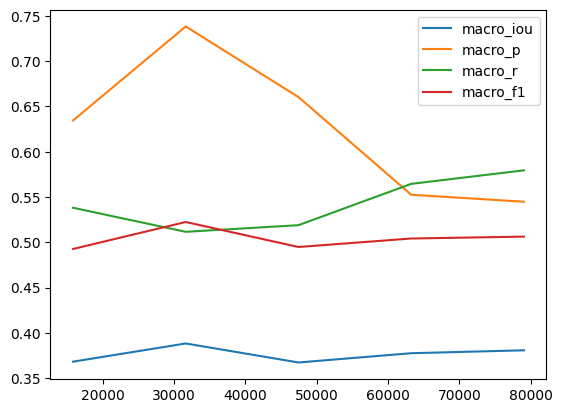

In [29]:
# Plot metrics with regard to training steps
steps, mets = run_man.get_run_metrics('runs/ood/mistral/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0')

for mn in ['macro_iou', 'macro_p', 'macro_r', 'macro_f1']:
# for mn in ['micro_iou', 'micro_p', 'micro_r']:
    plt.plot(steps, mets[mn], label = mn)
plt.legend()

In [31]:
mets

,doc_macro_f1,doc_macro_iou,doc_macro_p,doc_macro_r,macro_f1,macro_iou,macro_p,macro_r,micro_f1,micro_iou,micro_p,micro_r
0,0.823106,0.809600,0.922408,0.862671,0.415770,0.291860,0.595086,0.400382,0.461046,0.299584,0.637018,0.361253
1,0.838035,0.823903,0.928694,0.869648,0.444602,0.315088,0.645989,0.410266,0.491539,0.325854,0.679149,0.385145
2,0.845451,0.834670,0.967197,0.851819,0.414388,0.296826,0.739717,0.357507,0.463038,0.301269,0.805566,0.324893
3,0.849832,0.836703,0.943058,0.870423,0.451160,0.322174,0.692472,0.405592,0.505018,0.337809,0.745111,0.381946
4,0.842676,0.826418,0.901468,0.896577,0.477249,0.337523,0.563148,0.496372,0.541670,0.371432,0.602652,0.491896


In [32]:
run_dir = Path('runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)
ckpt_dir = ckpt_dirs[-1]
# get detail results
save_path = ckpt_dir / f'detail_metrics_ood_sampled.csv'
met_df_ood = pd.read_csv(save_path)
iou_mat_ood = met_df_ood['micro_iou']

save_path = ckpt_dir / f'detail_metrics_id_sampled.csv'
met_df_id = pd.read_csv(save_path)
iou_mat_id = met_df_id['micro_iou']

IndexError: list index out of range

In [ ]:
all_info = pd.read_csv('data/clause/all_info.csv')
q2name = {i: row['clause_type'] for i,row in all_info.iterrows()}

In [ ]:
def plot_clause_bar(met_df):
    x_labels = met_df['q_id'].apply(lambda k: q2name[k]).to_list()
    y = met_df['micro_iou'].to_list()
    ax = plt.gca()
    # fig, ax = plt.subplots()
    ax.barh(range(len(y)), y)
    ax.set_yticks(range(len(y)))
    ax.set_yticklabels(x_labels)

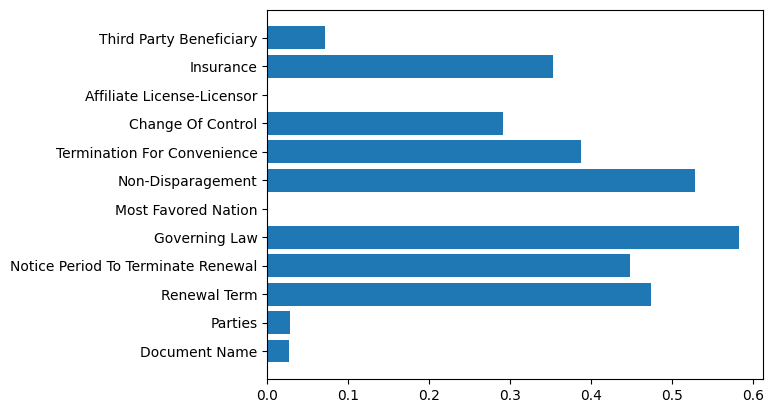

In [ ]:
plot_clause_bar(met_df_ood)

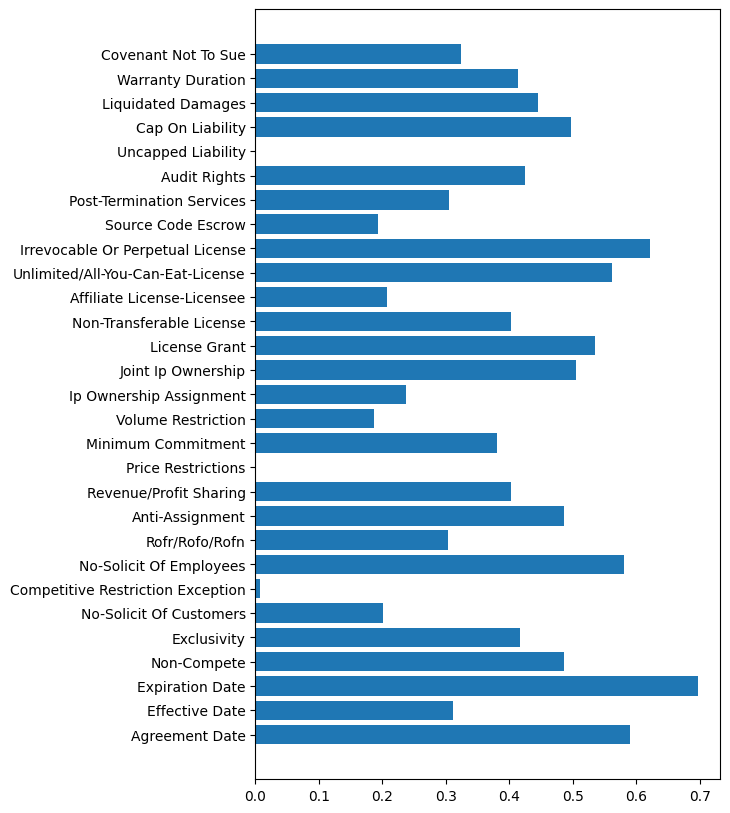

In [ ]:
plt.figure(figsize = (6,10))
plot_clause_bar(met_df_id)

In [67]:
met_df_ood['q_id'].apply(lambda k: q2name[k])

0                          Document Name
1                                Parties
2                           Renewal Term
3     Notice Period To Terminate Renewal
4                          Governing Law
5                    Most Favored Nation
6                      Non-Disparagement
7            Termination For Convenience
8                      Change Of Control
9             Affiliate License-Licensor
10                             Insurance
11               Third Party Beneficiary
Name: q_id, dtype: object

### Loss Plot

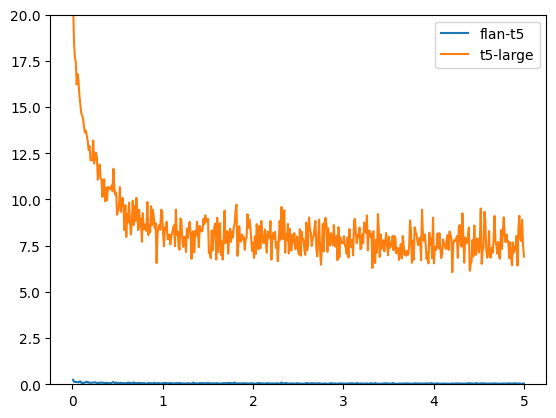

In [19]:
loss_dt = {
    'flan-t5': get_loss_df_norm('runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0'),
    # 'flan-t5_yn': get_loss_df_norm('runs/ood/flan-t5-large/seed42_tr29/pmt_01_yes_no_lr1e-4_bs16_wd0.0'),
    't5-large': get_loss_df_norm('runs/ood/t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0'),
    # 'llama3': get_loss_df_norm('runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0'),
    # 'llama3_kv': get_loss_df_norm('runs/ood/llama3/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0'),
    # 'llama3_yn': get_loss_df_norm('runs/ood/llama3/seed42_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0'),
    # 'llama3_ynkv': get_loss_df_norm('runs/ood/llama3/seed42_tr29/pmt_01_yes_no_lr1e-5_bs16_wd0.0'),
    # 'phi1': get_loss_df_norm('runs/ood/phi-1_5/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0'),
    # 'mistral': get_loss_df_norm('runs/ood/mistral/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0'),
    # 'mistral_yn': get_loss_df_norm('runs/ood/mistral/seed42_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0'),
}

plot_multiple_loss(loss_dt, y_lim = 20)

In [28]:
x = pd.DataFrame({'a': [1,1,2,3], 'b': [1,2,3,4], 'c': [5,6,7,8]})
r = x.groupby('a').apply(lambda k: k.mean())
# r = x.groupby(['a', 'b']).apply(lambda k: pd.Series([k['a'].mean(), k['b'].mean()], index = ['am', 'bm']))
print(type(r))
print(r)

<class 'pandas.core.frame.DataFrame'>
     a    b    c
a               
1  1.0  1.5  5.5
2  2.0  3.0  7.0
3  3.0  4.0  8.0


In [23]:
r2 = r.reset_index()
print(r2)

   a  b   am   bm
0  1  1  1.0  1.0
1  1  2  1.0  2.0
2  2  3  2.0  3.0
3  3  4  3.0  4.0


In [30]:
r['a'].to_dict()

{1: 1.0, 2: 2.0, 3: 3.0}